Data loaded from 'pima-indians-diabetes.csv' with size: 768
Training set size: 552, Test set size: 216
Classes found in the dataset: [0.0, 1.0]
Data has a class key of 0 with count of 347
Data has a class key of 1 with count of 205
Classes found in the dataset: [0.0, 1.0]
Data has a class key of 0 with count of 500
Data has a class key of 1 with count of 268
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-* 
Summary sample:
Attributes:[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0, 1.0], mean = 38.4696666667, stdev = 48.2961124833
Attributes:[1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0, 0.0], mean = 26.5501111111, stdev = 31.1197437347
Attributes:[8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672, 32.0, 1.0], mean = 34.6635555556, stdev = 59.585319952

Data sorted by class value: {0.0: [(3.298, 3.01718458262189), (109.98, 26.14119975535359), (68.184, 18.063075413305828), (19.664, 14.889947113744254), (68.792, 98.86528929231767), (30.30419999999996, 7.689855011650112), (0.42973400000000017, 0

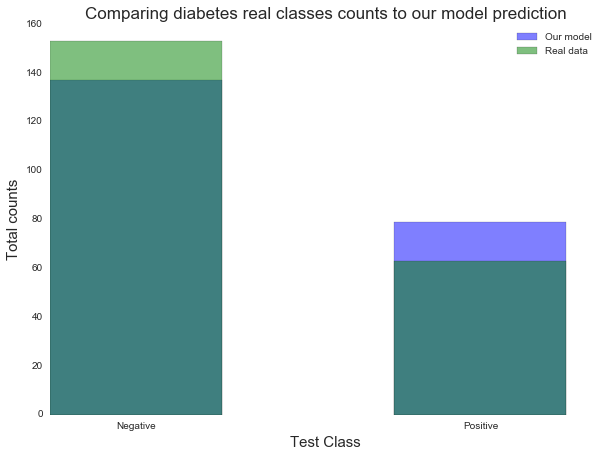

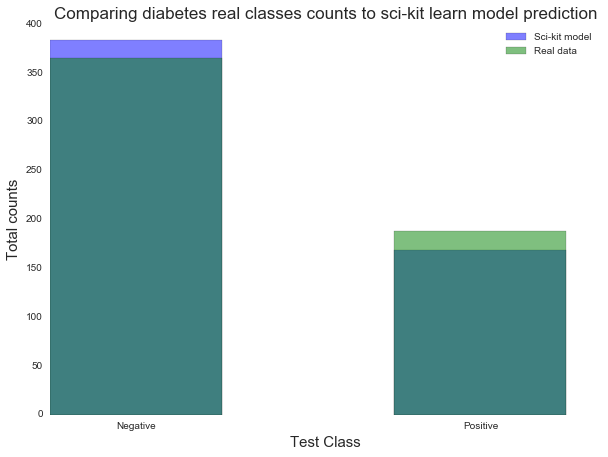

In [276]:
"""We will follow the steps below to execute this tutorial:

* Prepare the Data: Load the data from a file and split it into training and test datasets. One can also load directly from the online database but this should be covered in a different tutorial.
* Split the Data: We split our data, using a given ratio, to create our training set and test set.
* Classify our Data:  We divide the training data into classes (using the given ones) such that we can associate probabilities with each class.
* Build the Model: We use the Gaussian distribution function (equation above) to create our probability calculator. This require to calculate the mean $\mu$ and the standard deviation $\sigma$ of each set of attributes and then we associate that with the given classes. 
* Predict: After training our model we use the outcome (the summary/result of the Gaussian model evaluation for each class), we generate predictions given the test the model outcome.
* Measure Accuracy: We check how accurate is our model
* Compare Accuracy: We compare the prediction made by our model to that made by 'scikit-learn' model."""

import os, csv, random, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from pandas import Series
import matplotlib.pyplot as plt


class Data_Manipulate(object):
    def __init__(self, _folder, _file):
        self._folder = _folder
        self._file = _file
        #self._dataset = _dataset
        
    def data_loader(self,):
        _dir = os.path.join(os.path.dirname(os.path.realpath("__file__")), self._folder)
        file_path = _dir+'/'+self._file
        data = csv.reader(open(file_path, "rb"))
        dataset = list(data)
        for line in range(len(dataset)):
            dataset[line] = [float(x) for x in dataset[line]] 
        dataset = dataset[:-1]
        print "Data loaded from '{0}' with size: {1}".format(self._file, len(dataset))
    
        return self._file, dataset
    
    def data_splitter(self, _dataset, split_ratio):
        train_size = int(len(_dataset)*split_ratio)
        train_set = []
        test_set = list(_dataset)
        while len(train_set) < train_size:
            index = random.randrange(len(test_set))
            train_set.append(test_set.pop(index))
        print "Training set size: {0}, Test set size: {1}".format(abs(len(train_set)), len(test_set))
        
        return [train_set, test_set]
    
class Data_Classify(object):
    
    """Classifications: a simple scenario that we take each vector from our dataset (i.e. row by row) and 
    and test it against our argument of classification: the vectors that contain large number of 
    elements that are a like will be put in same class, and so on"""
    
    def __init__(self, _dataset):
        self._dataset = _dataset
        
    def data_class(self, train_set):
        _class = {}
        for x in range(len(self._dataset)):
            _row = self._dataset[x]
            if (_row[-1] not in _class): 
                #[-1] means takes the last element and classify accordingly
                # the reason of that because our 'class:0,1' is at the end of the row
                _class[_row[-1]] = []
            _class[_row[-1]].append(_row)
            
        print "Classes found in the dataset: {0}".format(_class.keys())
        for i in range(len(_class.keys())):
            print "Data has a class key of {0} with count of {1}".format(i, 
                [item[-1] for item in train_set].count(_class.keys()[i]))
       
        return _class

class Data_Summary(object):
    
    """- Here are our estimation tools, the mean and the standard deviation 
    - We put the training data, after measuring the mean and standard deviation, 
    into summary class, such that we will have [(mean_1, stdev_1), ... (mean_n, stdev_n)]
    - Separat the training dataset into instances grouped by class, then calculate the 
    summaries (which decrib the mean and stdev, from above fucntion) for each attribute 
    this should give {class: (mean, stdev)} such that: 
    {0: [(m1, st1), (m2, st2), ...], 1: [(m1, st1), (m2, st2), ...]}"""
    
    def __init__(self, _dataset):
        #Data_Classify.__init__(self, _dataset)
        self._dataset = _dataset
        
    #@staticmethod
    def mean(self, enteries):
        enteries = enteries#[:-1]
        mean = sum(enteries)/float(len(enteries))
        #print mean
    
        return mean

    #@staticmethod
    def stdev(self, enteries):
        enteries = enteries#[:-1]
        _mean = self.mean(enteries)
        variance = sum([pow(x-_mean,2) for x in enteries])/float(len(enteries)-1)
        _stdev = math.sqrt(variance)
    
        return _stdev
    
    def data_summary(self, data):
        summary = [(self.mean(attribute), self.stdev(attribute)) for attribute in zip(*data)]
        del summary[-1]

#         print '-*'*25, '\nSummary sample:'
#         for i in range(len(summary[:3])): 
#             print('Attributes:{0}, mean = {1}, stdev = {2}').format(
#                 data[i], 
#                 self.mean(data[i]), 
#                 self.stdev(data[i]))
#         print '-*'*25
        
        return summary
    
    def sort_data(self, dataset):
        init = Data_Classify(dataset)
        separated = init.data_class(dataset)
        classes = {}
        for classValue, instances in separated.iteritems():
            classes[classValue] = self.data_summary(instances)
            
        print '-*'*25, '\nSummary sample:'
        for i in range(len(dataset[:3])): 
            print('Attributes:{0}, mean = {1}, stdev = {2}').format(
                dataset[i], 
                self.mean(dataset[i]), 
                self.stdev(dataset[i]))

        print('\nData sorted by class value: {0}').format(classes)
        print '-*'*25
        
        return classes

class Probability_Calculator(object):
    """
    All that being given, we are now ready to carry our predictions using the training set. 
    The process is now simple, we just need to allow for this scenario: calculate the probability 
    that a given set of attributes will belong to a specific class, then we mark the class with 
    the highest probability scor as our prediction. In steps:
        -----------------------------------------------------
        Calculate Gaussian Probability Density Function per class,
        Calculate all the probabilities for all classes,
        Predict,
        Measure the model accuracy.
        -----------------------------------------------------
        """
#     def __init__(self, _trainSet, _testSet):
#         self._trainSet = _trainSet
#         self._testSet = _testSet
        
    def gaussian_estimator(self, x, mean, stdev):
        base = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
        estimator = (1.0 / (math.sqrt(2*math.pi) * stdev)) * base
    
        return estimator
    
    def class_probability(self, train, test):
        probabilities = {}
        for target, vector in train.iteritems():
            probabilities[target] = 1 # we need to have initial value here.
            for i in range(len(vector)):
                mean, stdev = vector[i]
                x = test[i]
            probabilities[target] *= self.gaussian_estimator(x, mean, stdev)
            
        return probabilities
    
    def predict(self, train_set, test_set):
        predictions = []
        for i in range(len(test_set)):
            probabilities = self.class_probability(train_set, test_set[i])
            _class, _prob = None, -1
            for Class, probability in probabilities.iteritems():
                if _class is None or probability > _prob:
                    _prob = probability
                    _class = Class
            predictions.append(_class)
        
        print 'Summary output of predictions:'
        for key in range(len(train_set.keys())):
            print "Class {0} counts are {1}".format(train_set.keys()[key], predictions.count(key))
        print '-'*45
        
        return predictions
    
    def accuracy(self, test_set, predictions):
        correct = 0
        for x in range(len(test_set)):
            if test_set[x][-1] == predictions[x]:
                correct += 1
        accurate = (correct/float(len(test_set))) * 100.0
        
        print('Accuracy of our model reads: {0}%').format(accurate)
        print '-'*50
    
        return accurate
       
        
# self test:---
if __name__ == '__main__':
    file_ = 'pima-indians-diabetes.csv'
    folder_ = 'data'
    data_manipulate = Data_Manipulate(folder_, file_)
    _file, _dataset = data_manipulate.data_loader()
    split_ratio = 0.72
    train_set, test_set = data_manipulate.data_splitter(_dataset, split_ratio)
    data_classify = Data_Classify(_dataset)
    data_classify.data_class(train_set)
    
    summary = Data_Summary(train_set)  
    #summary.data_summary()
    trained_data = summary.sort_data(_dataset)
    
    ### --- data below is just for testing:-
    dumy_test= [[1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0,'?'],
            [6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0, '?'], 
        [5.0, 116.0, 74.0, 0.0, 0.0, 25.6, 0.201, 30.0, '?'], 
        [3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.248, 26.0, '?']]
    dumy_trained = {
        0.0: [(3.2271386430678466, 2.949029689226637), (110.24188790560471, 26.761944476530694), 
              (67.45132743362832, 18.73514771938097), (19.20353982300885, 15.111905623533811), 
              (66.33038348082596, 90.01671437578825), (30.26312684365783, 7.943854214405065), 
              (0.4464513274336284, 0.3133357366573049), (30.61061946902655, 10.94047933486743)], 
        1.0: [(4.7650273224043715, 3.77593316816627), (143.24043715846994, 32.327090395428655), 
              (71.12021857923497, 21.66190701061604), (22.56830601092896, 18.635735518713098), 
              (98.33879781420765, 131.7750955004444), (35.764480874316945, 7.780243762136156), 
              (0.5579125683060112, 0.3902112882228733), (36.80327868852459, 10.331568509788598)]}
    
    #probabilities = Probability_Calculator()
    #probabilities.predict(dumy_trained, dumy_test)
    ###--------
    
    probabilities = Probability_Calculator()
    predictions = probabilities.predict(trained_data, test_set)
    probabilities.accuracy(test_set, predictions) 
    
    #------------------------ Plotting:
    def plotting_data(real_count, predicted_count, title, legends):
        fig, ax = plt.subplots(1, figsize=(10,7))
        #fig, ax1 = plt.subplots(figsize=(9, 7))
        fig.subplots_adjust(left=0.115, right=0.88)
        fig.canvas.set_window_title(title)
        
        bar_width = 0.5
        index = range(len(p_counts))
        tick_pos = [i+(bar_width/2) for i in index]

        ax.bar(index, predicted_count, width=bar_width, label=legends[0], alpha=0.5, color='blue')
        ax.bar(index, real_count, width=bar_width, label=legends[1], alpha=0.5, color='green')

        # Set the label and legends
        ax.set_ylabel("Total counts", fontsize=15)
        ax.set_xlabel("Test Class", fontsize=15)
        ax.set_axis_bgcolor('white')

        plt.legend(loc='upper right')
        plt.xticks(tick_pos, ['Negative', 'Positive'])
        plt.title(title, fontsize=17)
        # Set a buffer around the edge
        plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
        plt.savefig(title+'.png')
        
        plt.show()
        
        return plt
    
    
    #------------- Comparing our model to that of Sci-Kit learn model:
    def scikit_Gaussian(data, split_ratio):
        features = [item[:-1] for item in data]
        target = [item[-1] for item in data]
        features_train, features_test, target_train, target_test = train_test_split(
            features, target, 
            test_size = split_ratio, 
            random_state = 10)

        classfier = GaussianNB()
        classfier.fit(features_train, target_train)
        prediction = classfier.predict(features_test)

        accuracy = accuracy_score(target_test, prediction, normalize = True)
        print 'accuracy generated by scikit-learn: {}%'.format(accuracy * 100)
        print '-'*50

        return features, target, accuracy, prediction

    sci_features, sci_target, sci_accuracy, sci_predictions = scikit_Gaussian(_dataset, split_ratio)
    
    #-- plotting predictions for our model against real counts:
    p_samples = Series(predictions)
    p_counts = p_samples.value_counts()
    t_sample = [item[-1] for item in test_set]
    t_samples = Series(t_sample[:len(predictions)])
    t_counts = t_samples.value_counts()
    title = 'Comparing diabetes real classes counts to our model prediction'
    legends = ['Our model', 'Real data']
    plotting_data(t_counts, p_counts, title, legends)
    
    #-- plotting predictions for sci-kit learn model against real counts:
    p_samples = Series(sci_predictions)
    p_counts = p_samples.value_counts()
    t_samples = Series(sci_target[-len(sci_predictions):])
    t_counts = t_samples.value_counts()
    title = 'Comparing diabetes real classes counts to sci-kit learn model prediction'
    legends = ['Sci-kit model', 'Real data']
    plotting_data(t_counts, p_counts, title, legends)
